In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from datetime import datetime, date
import janitor as jn
import humanize 
import seaborn as sns

sns.set_context('paper')
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Cleaning

In [2]:
data = pd.read_csv('biofilm_2018_all.csv')
# data.columns
# Standard Janitor routines.
data = (jn.DataFrame(data)
        .clean_names()
        .remove_empty()
        .rename_column('is_contaminated_', 'is_contaminated')
        .fill_empty('is_contaminated', 0)
       )
data.columns
data = data[data['is_contaminated'] == 0]
# Add a date column.
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['date_humanized'] = data['date'].apply(lambda x: humanize.naturaldate(x))
data['Date'] = data['date_humanized']

# Get 3 columns of coded categoricals for ease of use with PyMC3.
data['isolate_macaque'] = [f'{m} ({i})' for i, m in zip(data.isolate, data.macaque_id)]
data['date_coded'] = pd.Categorical(data['date']).codes
data['isolate_coded'] = pd.Categorical(data['isolate']).codes
data['isolate_macaque_coded'] = pd.Categorical(data['isolate_macaque']).codes
data['st_coded'] = pd.Categorical(data['st']).codes
data['macaque'] = data['macaque_id'].str.split('-').str[0]
# View a sample of columns
data.shape

(582, 22)

In [3]:
dict(zip(data.isolate_macaque_coded, data.isolate_macaque))

{0: '1-11 (11)',
 1: '1-14 (46)',
 2: '1-15 (90)',
 3: '2-11 (13)',
 4: '2-14 (16)',
 5: '2-16 (85)',
 6: '2-16 (86)',
 7: '3-16 (100)',
 8: '4-13 (58)',
 9: '5-16 (91)',
 10: '6-16 (83)',
 11: '6-17 (124)',
 12: '7-17 (125)',
 13: '8-16 (128)',
 14: '9-16 (129)'}

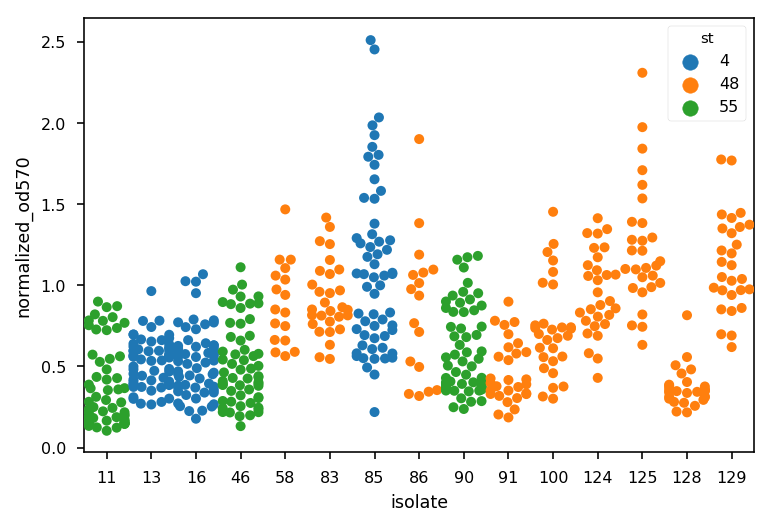

In [4]:
import seaborn as sns
sns.swarmplot(x='isolate', y='normalized_od570', hue='st', data=data)

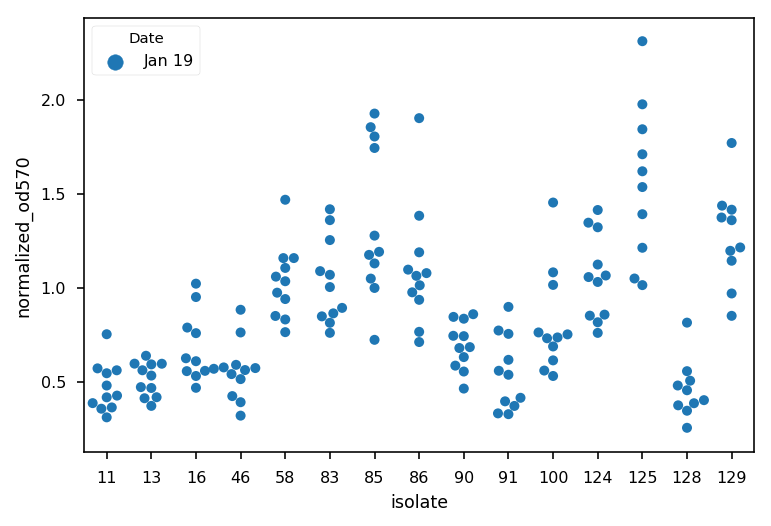

In [5]:
sns.swarmplot(x='isolate', y='normalized_od570', hue='Date', data=data[data['date_humanized'] == 'Jan 19'])

In [6]:
sorted(set(data['date']))

[Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-01-10 00:00:00'),
 Timestamp('2018-01-12 00:00:00'),
 Timestamp('2018-01-19 00:00:00'),
 Timestamp('2018-01-25 00:00:00'),
 Timestamp('2018-03-09 00:00:00')]

In [7]:
with pm.Model() as all_model:
    shape = len(set(data['isolate_macaque_coded']))

    BoundNormal = pm.Bound(pm.Normal, lower=0)
    mu_all = BoundNormal('mu_all', mu=0, sd=100, shape=(shape,))[data['isolate_macaque_coded']]
    sd_all = pm.HalfCauchy('sd_all', beta=1, shape=(shape,))[data['isolate_macaque_coded']]
    nu = pm.Exponential('nu', lam=0.5)
    
    like = pm.StudentT('like', mu=mu_all, sd=sd_all, nu=nu, observed=data['normalized_od570'])

In [8]:
with all_model:
    all_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:06<00:00, 364.03it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c15281c88>,
      dtype=object)

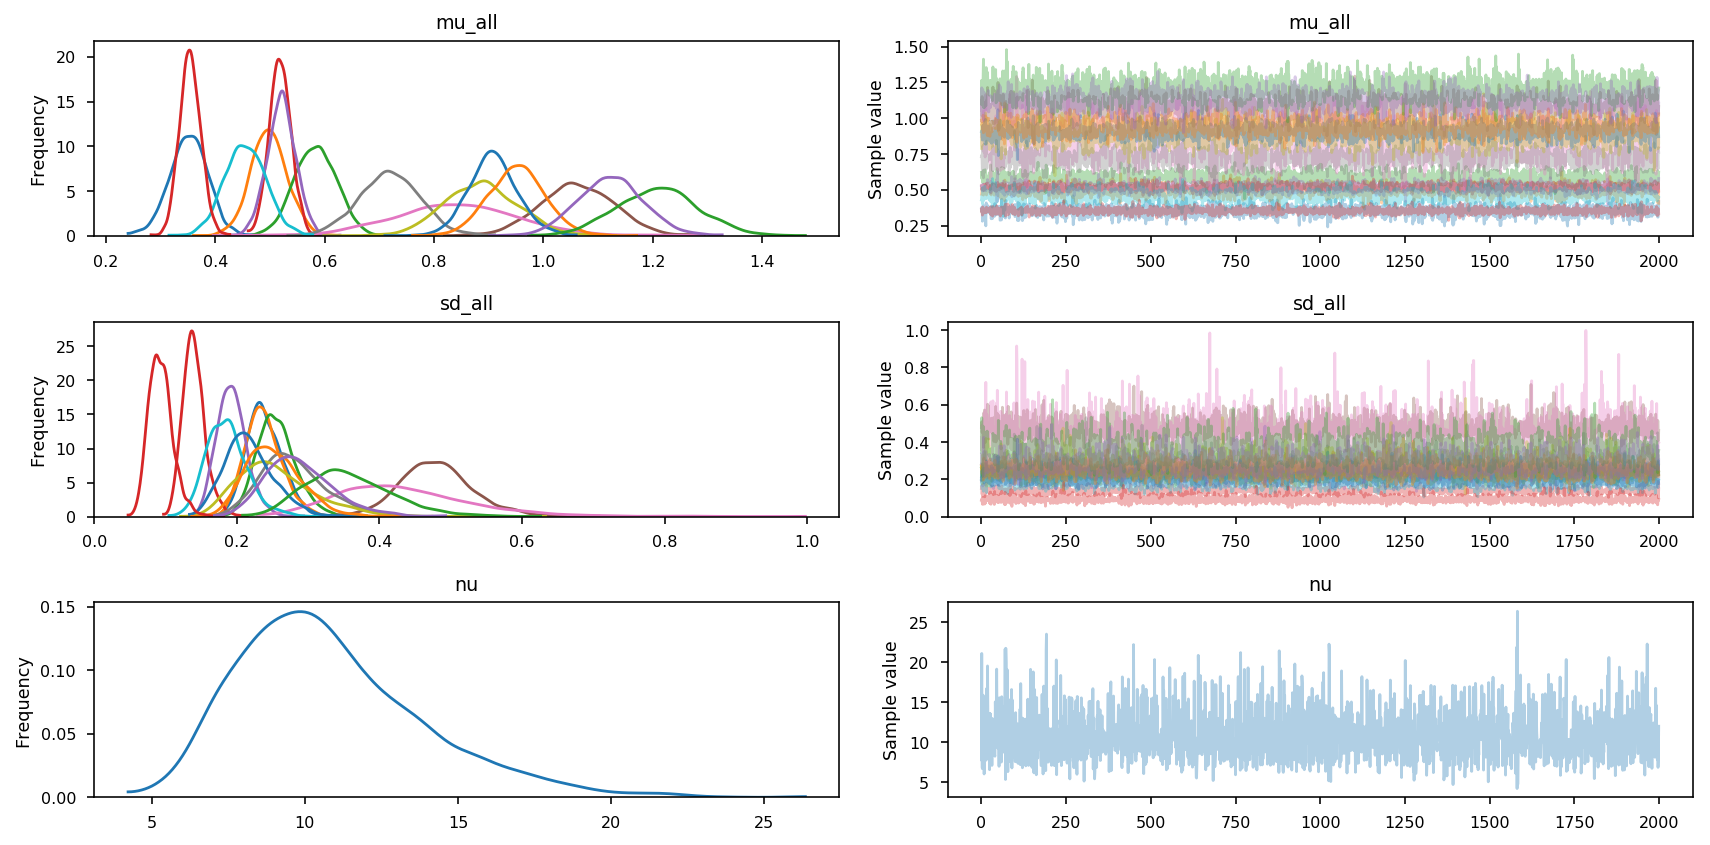

In [9]:
pm.traceplot(all_trace)

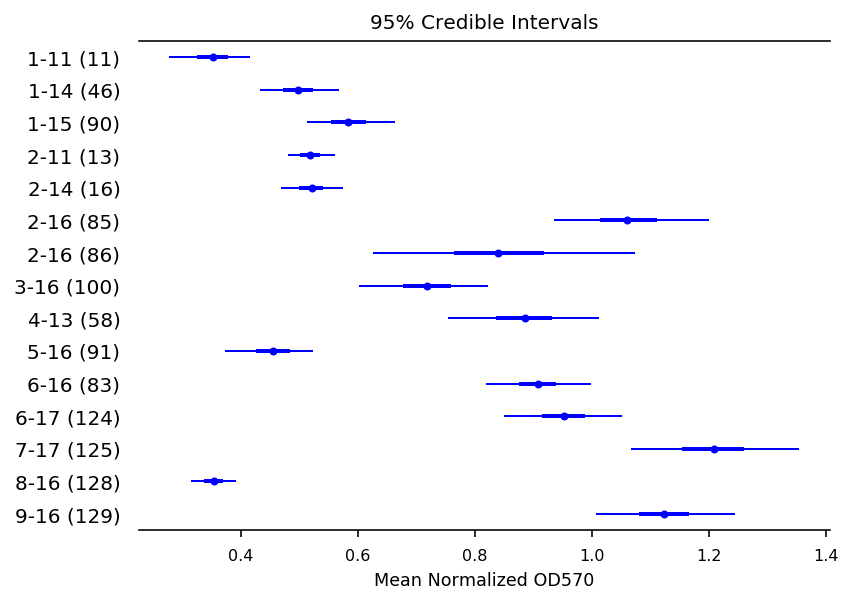

In [10]:
pm.forestplot(all_trace, 
              varnames=['mu_all'], 
              ylabels=[str(i) for i in sorted(set(data['isolate_macaque']))],
              xtitle='Mean Normalized OD570')

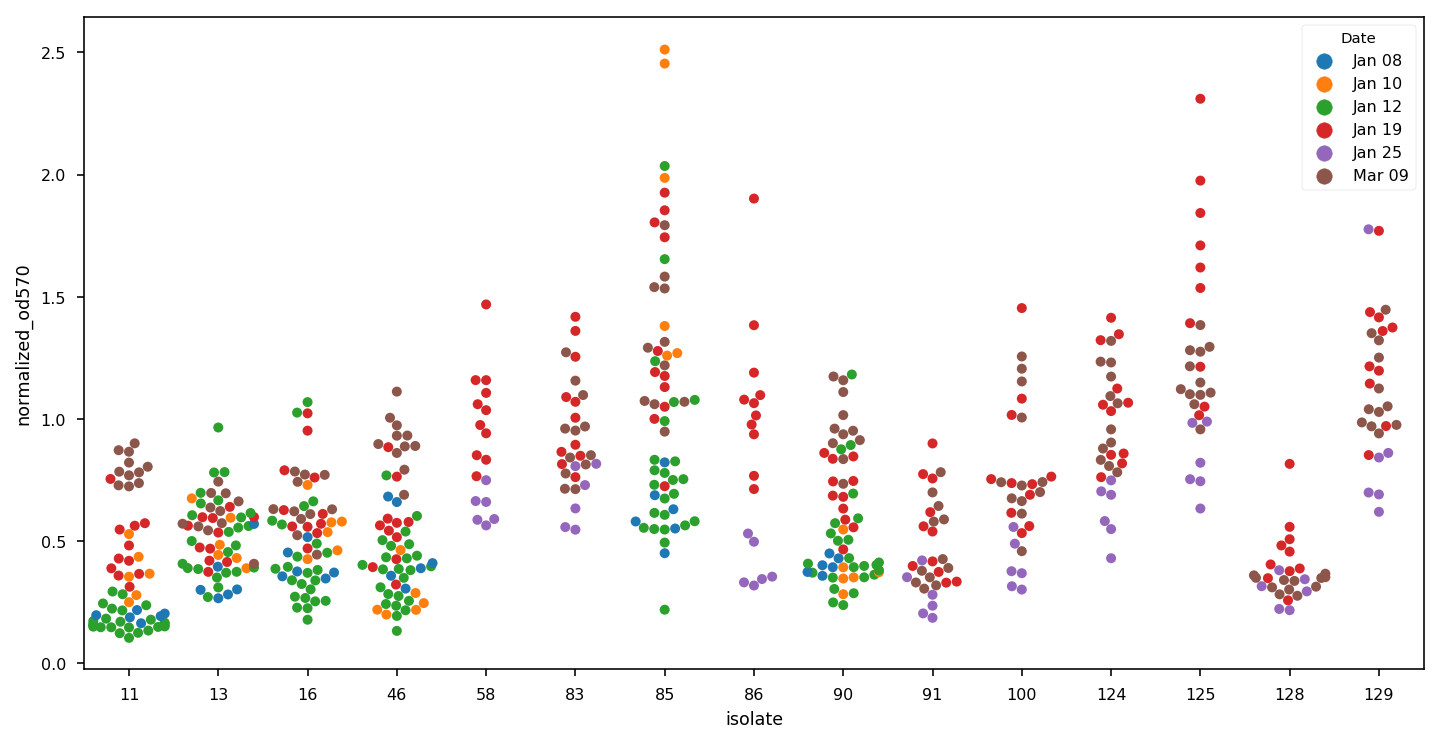

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sns.swarmplot(x='isolate', y='normalized_od570', hue='Date', data=data, ax=ax)

In [12]:
macaque_isolate_order = [11, 46, 90, 13, 16, 85, 86, 100, 58, 91, 83, 124, 125, 128, 129]

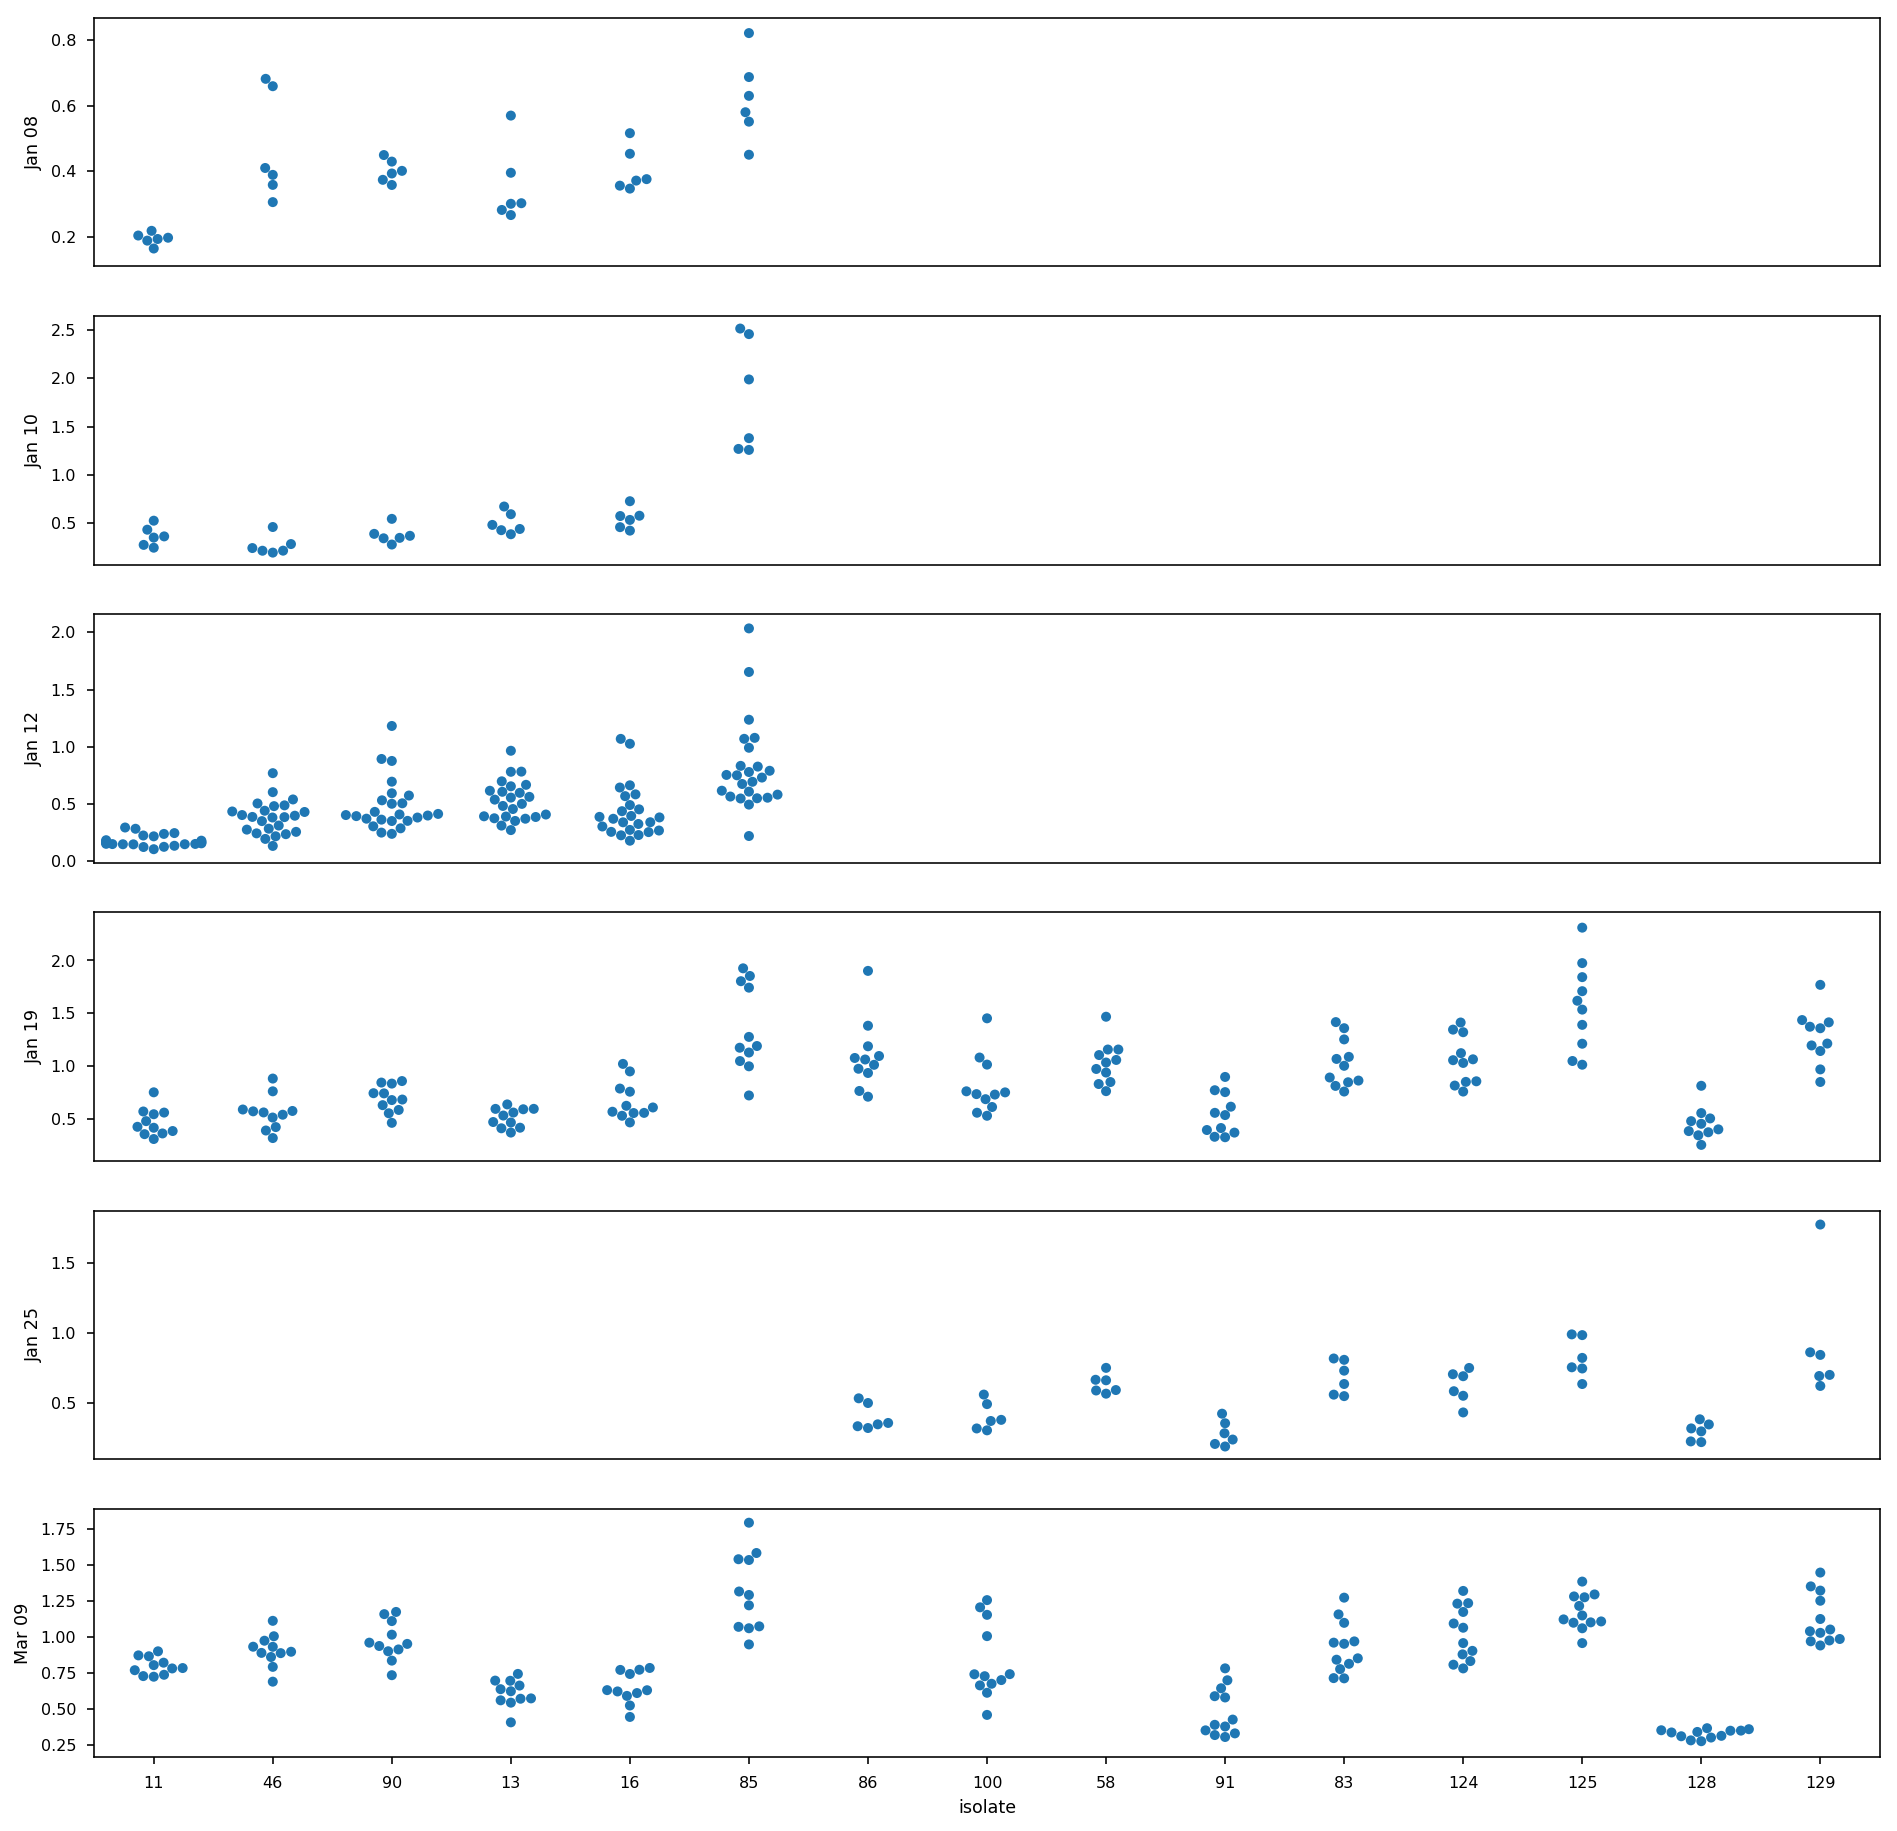

In [13]:
from matplotlib.gridspec import GridSpec
# Let's build a custom swarm plot panel. This is essentially a vertical concatenation of swarm plots.
nrows = len(set(data['date']))
ncols = 1
gs = GridSpec(nrows, ncols)
dates = data[['date_humanized', 'date_coded']].drop_duplicates().set_index('date_coded').to_dict(orient='index')
dates

fig = plt.figure(figsize=(16, 16))
for code in range(6):
    data_subdate = data[data['date_coded'] == code]
    ax = fig.add_subplot(gs[code])
    sns.swarmplot(x='isolate', y='normalized_od570', hue='date', data=data_subdate, ax=ax, order=macaque_isolate_order)
    ax.legend_.remove()
    ax.set_ylabel(f'{dates[code]["date_humanized"]}')
    
    if code != 5:
        ax.set_xticks([])
        ax.set_xlabel('')

# Make Figures for Mia

First figure: swarm plot on left, 95% CI on right.

- Swarm plot:
    - x-axis: isolate, grouped by macaque ID
    - y-axis: normalized OD570
    - hue: date_humanized

In [14]:
all_trace['mu_all'].shape

(2000, 15)

In [15]:
macaque_isolate_order

[11, 46, 90, 13, 16, 85, 86, 100, 58, 91, 83, 124, 125, 128, 129]

In [16]:
code_isolate = dict(zip(data.isolate_coded, data.isolate))
isolate_macaque_id = dict(zip(data.isolate, data.macaque_id))
isolate_macaque = dict(zip(data.isolate, data.macaque))
macaque_id_order = [dict(zip(data.isolate, data.macaque_id))[k] for k in macaque_isolate_order]
macaque_id_order

['1-11',
 '1-14',
 '1-15',
 '2-11',
 '2-14',
 '2-16',
 '2-16',
 '3-16',
 '4-13',
 '5-16',
 '6-16',
 '6-17',
 '7-17',
 '8-16',
 '9-16']

In [17]:
isolate_macaque_id

{11: '1-11',
 13: '2-11',
 16: '2-14',
 46: '1-14',
 58: '4-13',
 83: '6-16',
 85: '2-16',
 86: '2-16',
 90: '1-15',
 91: '5-16',
 100: '3-16',
 124: '6-17',
 125: '7-17',
 128: '8-16',
 129: '9-16'}

In [18]:
macaque_id_order

['1-11',
 '1-14',
 '1-15',
 '2-11',
 '2-14',
 '2-16',
 '2-16',
 '3-16',
 '4-13',
 '5-16',
 '6-16',
 '6-17',
 '7-17',
 '8-16',
 '9-16']

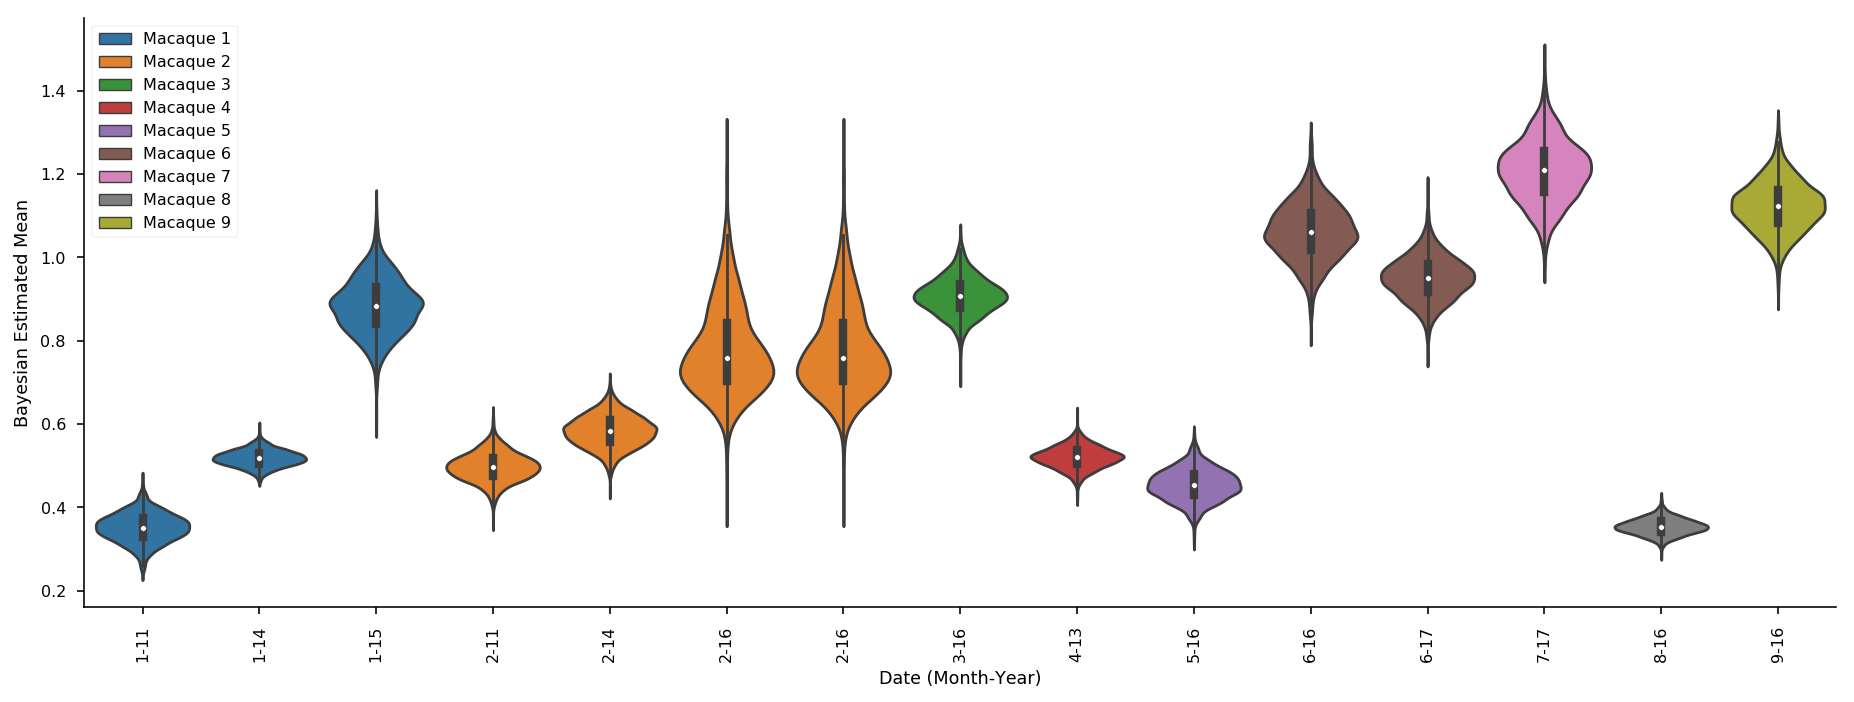

In [19]:
fig = plt.figure(figsize=(13, 5))
# ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(1,1,1)
# ax1 = sns.swarmplot(x='isolate_macaque', y='normalized_od570', hue='date_humanized', data=data, ax=ax1, order=macaque_id_order)
# ax1.set_xlabel('Macaque (Isolate)')
# ax1.set_xticks([])
# ax1.set_title('Raw Data')
# ax1.set_ylabel('Normalized OD570')
# # ax1.legend_.set_visible(False)
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

all_trace_df = pd.DataFrame(all_trace['mu_all'])
all_trace_df.columns = [code_isolate[i] for i in all_trace_df.columns]
all_trace_unstacked = pd.DataFrame(all_trace_df.unstack()).reset_index()
all_trace_unstacked.columns = ['isolate', 'sample', 'value']
all_trace_unstacked['macaque_id'] = [isolate_macaque_id[i] for i in all_trace_unstacked['isolate']]
all_trace_unstacked['macaque'] = [isolate_macaque[i] for i in all_trace_unstacked['isolate']]
all_trace_unstacked['isolate_macaque'] = [f'{m} ({i})' for i, m in zip(all_trace_unstacked.isolate, all_trace_unstacked.macaque_id)]

ax2 = sns.violinplot(x='macaque_id', y='value', data=all_trace_unstacked, dodge=False, hue='macaque', order=macaque_id_order, ax=ax2)
ax2.set_xlabel('Date (Month-Year)')
ax2.set_ylabel('Bayesian Estimated Mean')
ax2.legend_.set_visible(False)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
legend = ax2.legend()
for t in legend.get_texts():
    t.set_text(f'Macaque {t.get_text()}')
sns.despine()

plt.tight_layout()

plt.savefig('biofilm-figure.pdf')